# Current induced domain wall motion using STT

## Problem description

In this tutorial we show how Zhang-Li spin transfer torque (STT) can be included in micromagnetic simulations. To illustrate that, we will try to move a domain wall pair using spin-polarised current.

Let us simulate a two-dimensional sample with length $L = 500 \,\text{nm}$, width $w = 20 \,\text{nm}$ and discretisation cell $(2.5 \,\text{nm}, 2.5 \,\text{nm}, 2.5 \,\text{nm})$. The material parameters are:

- exchange energy constant $A = 15 \,\text{pJ}\,\text{m}^{-1}$,
- Dzyaloshinskii-Moriya energy constant $D = 3 \,\text{mJ}\,\text{m}^{-2}$,
- uniaxial anisotropy constant $K = 0.5 \,\text{MJ}\,\text{m}^{-3}$ with easy axis $\mathbf{u}$ in the out of plane direction $(0, 0, 1)$,
- gyrotropic ratio $\gamma = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$, and
- Gilbert damping $\alpha=0.3$.

## Domain-wall pair

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

# Micromagnetic system definition
system = mm.System(name='domain_wall_pair')
system.energy = mm.Exchange(A=A) + \
                mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

Because we want to move a DW pair, we need to initialise the magnetisation in an appropriate way before we relax the system.

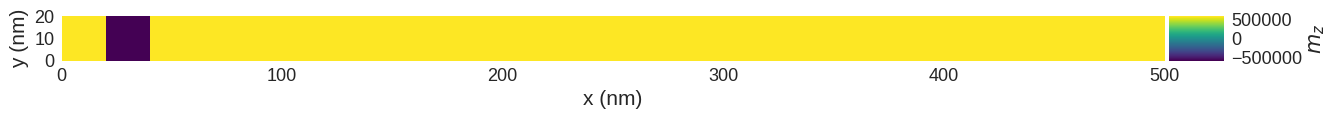

In [2]:
def m_value(pos):
    x, y, z = pos
    if 20e-9 < x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, nvdim=3, value=m_value, norm=Ms)

system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))

Now, we can relax the magnetisation.

In [3]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:26]... (2.2 s)


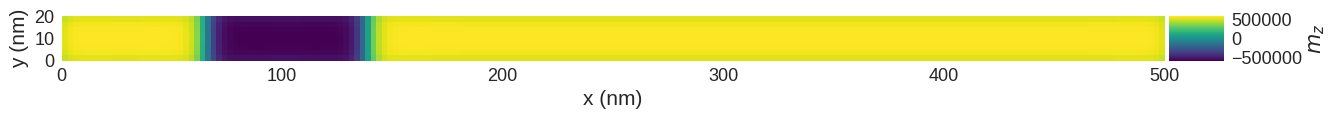

In [4]:
system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))

Now we can add the STT term to the dynamics equation.

In [5]:
ux = 400  # velocity in x-direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += mm.ZhangLi(u=ux, beta=beta)  # please notice the use of `+=` operator

And drive the system for $0.5 \,\text{ns}$:

In [6]:
td = mc.TimeDriver()
td.drive(system, t=0.5e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:26]... (1.5 s)


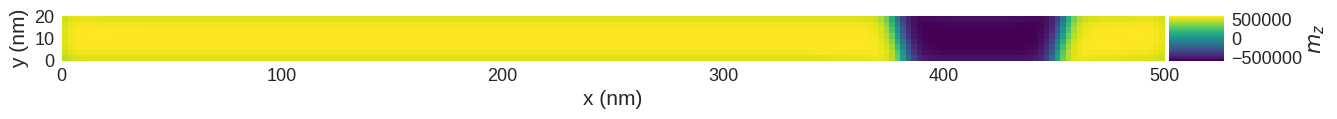

In [7]:
system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))

We see that the DW pair has moved to the positive $x$ direction. Now, let us visualise the motion using interactive plot.

In [8]:
import micromagneticdata as md

data = md.Data(system.name)

In [9]:
data[1].hv(kdims=["x", "y"])

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

## Single domain wall

Modify the previous code to obtain one domain wall instead of a domain wall pair and move it using the same current.

**Solution**

In [10]:
# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

# Micromagnetic system definition
system = mm.System(name='domain_wall')
system.energy = mm.Exchange(A=A) + \
                mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

def m_value(pos):
    x, y, z = pos
    # Modify the following line
    if 20e-9 < x:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    # We have added the y-component of 1e-8 to the magnetisation to be able to 
    # plot the vector field. This will not be necessary in the long run.
    
system.m = df.Field(mesh, nvdim=3, value=m_value, norm=Ms)

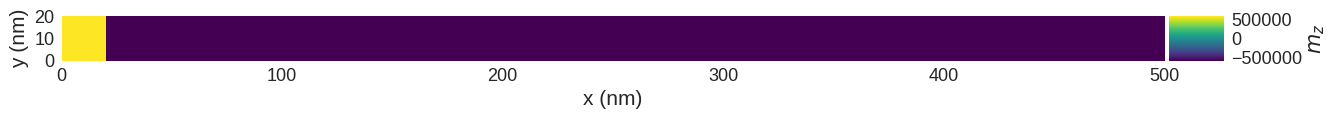

In [11]:
system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))

In [12]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:26]... (1.2 s)


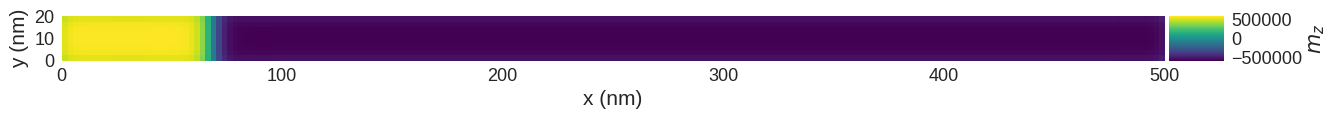

In [13]:
system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))

In [14]:
ux = 400  # velocity in x direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += mm.ZhangLi(u=ux, beta=beta)

td = mc.TimeDriver()
td.drive(system, t=0.5e-9, n=100)

Running OOMMF (ExeOOMMFRunner)[2023/08/10 16:26]... (1.5 s)


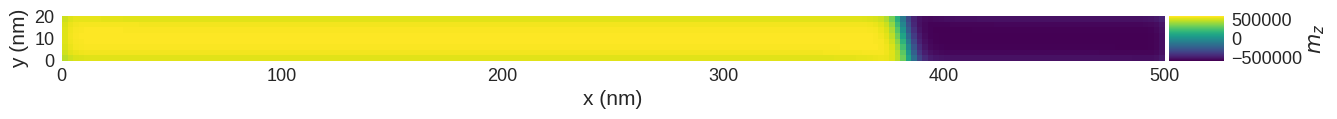

In [15]:
system.m.z.sel('z').mpl(scalar_kw={"colorbar_label": "$m_z$"}, figsize=(15, 10))